# 前言

`动量效应是指过去收益较高的股票，在未来一段时间内仍具有相对较好的收益`。 动量效应普遍存在于国外的股票市场中，但在A股市场中，动量效应却难寻踪迹。 众所周知，无论是`短端`涨跌幅因子还是`长端`涨跌幅因子，在A股市场均呈现为显著的**反转效应**。A 股市场具有强反转这一特征属性，使得有效的动量因子变得稀少而珍贵。

考虑到长端涨跌幅的反转效应弱于短端涨跌幅的反转效应，传统研究也尝试从长端涨跌幅之中切割出具有动量的部分。`传统切割方案基于时间维度，使用长端涨跌幅与短端涨跌幅作差，以希望切割后的部分能够呈现出动量效应。`但整体上动量效应并不显著。

下图给出了涨跌幅因子时间维度切割的直观理解。我们以6个月涨跌幅Ret6m为例，切割得到Ret1m（近端区域）与Ret6m-Ret1m（远端区域）两个部分。在短端涨跌幅Ret1m之中，同时存在着强反转与弱动量两个部分，因此整体上短端涨跌幅呈现为强反转效应。而在Ret6m-Ret1m 部分，同时存在着反转与动量两个部分，但两者强度差异不大，因此整体上长端涨跌幅-短端涨跌幅的动量效应微弱。**基于动量反转在时间维度上的分布特征，我们可以发现，仅仅时间维度上的简单切割，难以构造有效的动量因子。**

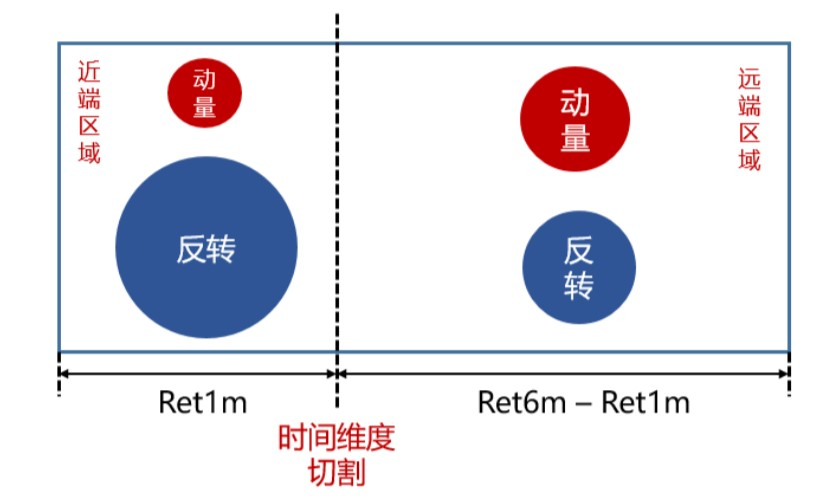

In [2]:
# 引入库
import sys
sys.path.append('../../..')

from BuildPeriodDate import (GetTradePeriod,tdaysoffset)
import numpy as np
import pandas as pd
import empyrical as ep
import alphalens as al
import scipy.stats as st
import alphalens.performance as perf
from alphalens import plotting

from jqdata import *
from jqfactor import (Factor,calc_factors)

import itertools
from typing import (Tuple,List,Union)
from functools import reduce
from tqdm import tqdm_notebook
from dateutil.parser import parse


import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams['font.family']='serif' # pd.plot中文
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

**工具函数准备**

**1.股票池过滤**

- 过滤上市小于60日的股票；
- 过滤停牌大于20日的股票;
- 过滤ST,\*ST股票

In [3]:
# 获取股票池
def get_stockpool(symbol: str, watch_date: str) -> list:
    '''获取股票池'''

    if symbol == 'A':
        stockList = get_index_stocks('000001.XSHG', date=watch_date) + get_index_stocks(
            '399107.XSHE', date=watch_date)
    else:
        stockList = get_index_stocks(symbol, date=watch_date)
        
    stockList = del_st_stock(stockList, watch_date)  # 过滤ST
    stockList = del_iponday(stockList, watch_date)   # 过滤上市不足60日
    stockList = del_pause(stockList,watch_date)      # 过滤当日停牌的股票
    return stockList

def del_st_stock(securities: list, watch_date: str) -> list:
    '''过滤ST股票'''

    info_ser = get_extras('is_st', securities,
                          end_date=watch_date, df=True, count=1).iloc[0]

    return info_ser[info_ser == False].dropna().index.tolist()

def del_iponday(securities: list, watch_date: str, N: int = 60) -> list:
    '''返回上市大于N日的股票'''
    dic = {x: get_security_info(x, date=watch_date).start_date for x in securities if get_security_info(
        x, date=watch_date) != None}
    return [code for code, start_date in dic.items() if (parse(watch_date).date() - start_date).days > N]

def del_pause(securities:list,watch_date:str,N:int=20)->list:
    
    '''
    过滤停牌股,默认为过滤当日停牌的
    '''
    
    paused = get_price(securities,end_date=watch_date,count=N,fields='paused',panel=False)
    
    if N == 1:
        return paused.query('paused != 1')['code'].values.tolist()
    else:
        
        paused_num = paused.groupby('code')['paused'].sum()
        return paused_num[paused_num < N].index.values.tolist()

**2.因子构建**

In [4]:
# 因子构造
-

# 因子生成不同窗口期下的因子

def creat_factor(f: RetN_momentum,
                 period: Union[int, list],
                 mod: str,
                 group: Union[str, list] = None,
                 lamb: Union[float, list] = None) -> list:
    '''mod为sort,lamb'''

    if isinstance(lamb, float):

        lamb = [lamb]

    if isinstance(period, int):

        period = [period]

    if isinstance(group, str):

        group = [group]

    f_list = []

    def _func_sort():

        for g, p in itertools.product(group, period):

            f_ = f()
            f_.max_window = p
            f_.mod = mod
            f_.group = g
            f_list.append(f_)

        return f_list

    def _func_lamb():

        for lmb, p in itertools.product(lamb, period):

            f_ = f()
            f_.max_window = p
            f_.lamb = lmb
            f_.mod = mod
            f_list.append(f_)

        return f_list

    mod_dic = {'sort': _func_sort, 'lamb': _func_lamb}

    return mod_dic[mod]()

**3.获取因子**

In [5]:
# 因子计算
def prepare_data(symbol: str, start: str, end: str, last_date: str, factor_list: list) -> pd.DataFrame:
    '''
    symbol:股票池所属成份，A为全市场
    start,end:回测区间 频率为月度
    last_date:计算next_returns的最后一日的日期
    factor:构建的因子
    '''
    periods = GetTradePeriod(start, end, 'ME') # 月度_周期获取
    periods = periods + [last_date] 
    factor_dic = {}

    factor_names = [factor.name for factor in factor_list]

    for tradeDate, nextDate in tqdm_notebook(zip(periods[:-1], periods[1:]), total=len(periods)-1, desc='因子计算'):
        
        # 股票池
        stock_pool = get_stockpool(symbol, tradeDate.strftime('%Y-%m-%d'))
    
        # 因子获取
        
        factor = calc_factors(
            stock_pool, factor_list, start_date=tradeDate, end_date=tradeDate)
        
        factor_frame = dict2frame(factor)
        
        # 计算下期收益率
        close = get_price(stock_pool, end_date=tradeDate, count=1,
                          fields='close', panel=False).set_index('code')
        
        next_close = get_price(stock_pool, end_date=nextDate,
                               count=1, fields='close', panel=False).set_index('code')

        next_returns = next_close['close'] / close['close'] - 1
        next_returns.name = 'next_ret'
        
        # 合并
        tmp = pd.concat((factor_frame, next_returns), axis=1)
        factor_dic[tradeDate] = tmp # 放入容器

    factor_df = pd.concat(factor_dic)

    factor_df.index.names = ['date', 'code']
    
    return factor_df


def dict2frame(dic:dict)->pd.DataFrame:
    
    '''将data的dict格式转为df'''
    
    df = pd.concat((df.iloc[-1] for df in dic.values()),axis=1)
    df.columns = list(dic.keys())
    
    return df

# 涨跌幅因子交易行为维度的切割

通过上文的分析，构造有效动量因子的关键在于：探寻合适的维度将动量与反转进行切割区分。在讨论涨跌幅因子合适的切割维度之前，我们先从交易行为角度对反转效应进行分析。行为金融学理论表明，反转效应是投资者的交易行为引发的市场现象，股价反转很大程度上与投资者过度反应有关。资金的过度涌入与过度流出， 一定程度上都会导致股价的反转。因此我们思考：不同交易活跃程度下，动量和反转效应是否存在差异性？

我们从交易行为维度出发，尝试构造衡量交易活跃程度的指标来对涨跌幅因子进行切割。我们测试了日度振幅等指标的切割效果，最终给出了基于日度振幅的涨跌幅因子切割方案。具体切割步骤如下:

|步骤|说明|
|--|--|
|步骤1|对选定股票，回溯取其近N个交易日的数据;|
|步骤2|计算股票每日的**振幅**(HIGH/LOW-1);|
|步骤3|选择振幅较低的N/2交易日,涨跌幅加总,记为A因子;|
|步骤4|选择振幅较高的N/2交易日,涨跌幅贾总,记为B因子;|

我们选择不同窗口下的涨跌幅因子作为切割对象，对切割得到的A因子和B因子进行了测试。从下图因子IC均值结构对比我们发现：1)不同时间窗口下,A因子呈现出动量效应,B因子则呈现出反转效应;2)随着时间窗口增加，A因子的动量效应呈现出逐渐增强趋势，B因子的反转效应逐渐减弱(原始研报曲线明显，复现的结果并没那么的明显)。当窗口期为 120 交易日时(N=120),对应的A因子IC均值为0.025，动量效应较为显著。测试结果表明，基于日度振幅的涨跌幅因子切割方案，能够从长端涨跌幅中切割出有效的动量因子。

In [226]:
# 设置区间
start = '2014-01-01'
end = '2020-12-31'
last_date = '2021-01-31'

# 生成不同窗口期下的因子
f_list = creat_factor(RetN_momentum, list(
    range(21, 242, 20)), 'sort', ['A', 'B'])
    
# 获取因子数据 14m22s
factor_df1 = prepare_data(
    'A', start, end, last_date, f_list)

In [235]:
# 储存
factor_df1.to_csv('factor_df1.csv')

In [238]:
# 读取
factor_df1 = pd.read_csv('factor_df1.csv',index_col=[0,1],parse_dates=['date'])

In [6]:
# 计算ic
def src_ic(df:pd.DataFrame)->pd.DataFrame:
    
    '''计算IC'''
    
    f = [col for col in df.columns if col != 'next_ret']
    
    _ic = df[f].apply(lambda x:st.spearmanr(x,df['next_ret'])[0])
    
    return _ic

In [227]:
# IC计算
ic_df = factor_df1.fillna(0).groupby(level='date').apply(src_ic)

In [230]:
# 获取A组的mean ic
A_factor = ic_df.filter(regex='A_momentum').mean()
A_factor.index = A_factor.index.str.replace('\D', '')

# 获取B组的mean ic
B_factor = ic_df.filter(regex='B_momentum').mean()
B_factor.index = B_factor.index.str.replace('\D', '')

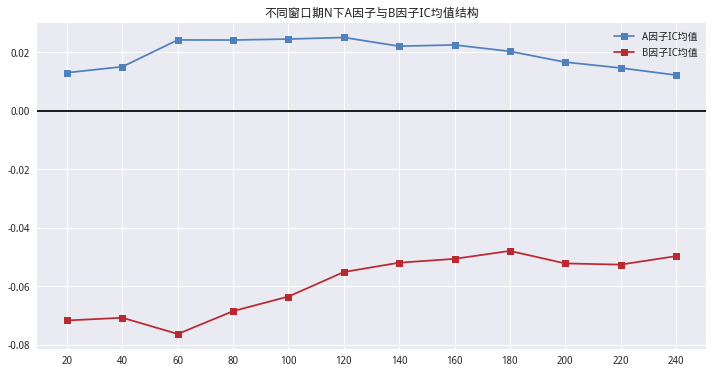

In [233]:
# 画图
fig, ic_mean_ax = plt.subplots(figsize=(12, 6))

ic_mean_ax.set_title('不同窗口期N下A因子与B因子IC均值结构')
ic_mean_ax.plot(A_factor, label='A因子IC均值', marker='s', color='#4F81BD')
ic_mean_ax.plot(B_factor, label='B因子IC均值', marker='s', color='#BA2830')
ic_mean_ax.axhline(0, color='black')
ic_mean_ax.legend()

# 切割得到的动量因子表现稳健

## 涨跌幅因子的内在结构

为了进一步探究涨跌幅因子的内在结构，我们分析不同交易活跃程度下，涨跌幅因子的动量反转特性。具体操作上，我们选择120交易日作为窗口期（N=120），并 按照振幅高低将160个交易日等分为十组，其中第一组对应振幅最低 10%交易日的涨跌幅加总，第十组对应振幅最高 10%交易日的涨跌幅加总。

我们测试了不同分组下涨跌幅因子的动量反转效应，下图给出了不同分组的IC均值结构。可以发现：在振幅较低的分组（第一组至第七组），对应涨跌幅因子呈现出较为显著的动量效应；随着振幅水平的进一步提高，涨跌幅因子的动量效应开始衰减（第八组）并转为反转效应（第九组至第十组）。在振幅水平最高的第十组，涨跌幅因子呈现出强反转效应。我们可以得出结论：低振幅水平下涨跌幅因子呈现动量效 应，高振幅水平下涨跌幅因子呈现反转效应，并且动量效应和反转效应的分布和强度具有不对称性。

In [19]:
# 设置区间
start = '2014-01-01'
end = '2020-12-31'
last_date = '2021-01-31'

# 生成不同窗口期下的因子
f_list2 = creat_factor(RetN_momentum, 121, 'q', 'A',list(range(1,11)))
    
# 获取因子数据 1h59m38 
# TODO:算法待优化耗时过长
factor_df2 = prepare_data(
    'A', start, end, last_date, f_list2)

In [20]:
# 储存
factor_df2.to_csv('factor_df2.csv')

In [48]:
# 读取
factor_df2 = pd.read_csv('factor_df2.csv',index_col=[0,1],parse_dates=['date'])

In [49]:
ic_df2 = factor_df2.fillna(0).groupby(level='date').apply(src_ic)

In [50]:
ic_mean = ic_df2.mean()
ic_mean.index = list(range(1,11))

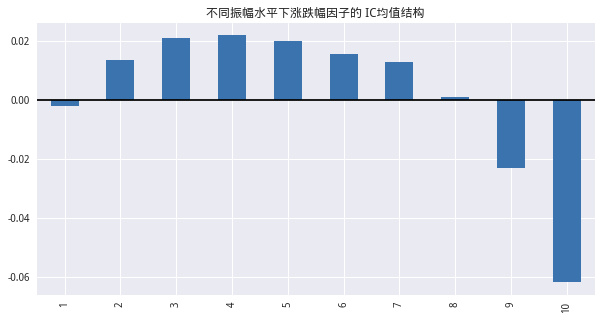

In [51]:
mpl.rcParams['font.family']='serif'
ic_mean.plot.bar(title='不同振幅水平下涨跌幅因子的 IC均值结构',figsize=(10,5),color='#3A73AD',rot=90)
plt.axhline(0,color='black');

## 切割得到的动量因子选股能力较为稳健

基于以上涨跌幅因子的内在结构，我们尝试构造有效的动量因子。具体操作上， 我们选择120交易日作为窗口期（N=120），同时引入切割比例λ，将振幅较低的λ比例交易日的涨跌幅加总，构造得到动量因子A(λ)。 从不同切割比例下A因子的IC均值和ICIR值走势下图上看：随着λ逐渐增加，IC均值与ICIR值均呈现出先增后降的走势，两者均在λ为30%左右达到峰值(原始研报为70%)。当λ为30%时，对应A因子的 IC均值为0.021，ICIR值为0.54，呈现为显著的动量效应。通过对比我们可以发现，上图与下图结论相互印证：当λ由10%逐渐增大到30%过程中，由于增量部分涨跌幅因子动量效应较为显著（第一组至第七组）， 因此整体A因子的动量效应呈现增强趋势；随着λ由30%进一步增大到100%过程中，由于增量部分涨跌幅因子逐渐衰减为反转效应（第八组-第十组），因此整体A因子的动量效应逐渐减弱，最终甚至呈现为反转效应（λ=100%）。

In [45]:
# 设置区间
start = '2014-01-01'
end = '2020-12-31'
last_date = '2021-01-31'

# 生成不同窗口期下的因子
f_list3 = creat_factor(RetN_momentum, 121, 'lamb', 'A',np.arange(0.1,1.1,0.1))
    
# 获取因子数据 1h59m38 
# TODO:算法待优化耗时过长
factor_df3 = prepare_data(
    'A', start, end, last_date, f_list2)

In [46]:
# 储存
factor_df3.to_csv('factor_df3.csv')

In [5]:
# 读取
factor_df3 = pd.read_csv('factor_df3.csv',index_col=[0,1],parse_dates=['date'])

In [6]:
factor_df3.columns = list(map(lambda x: '%.2f%%' %
                              x, range(10, 101, 10))) + ['next_ret']

In [10]:
# 计算ic
ic_df3 = factor_df3.fillna(0).groupby(level='date').apply(src_ic)

ic_mean2 = ic_df3.mean()
ic_std2 = ic_df3.std()

icir = ic_mean2 / ic_std2

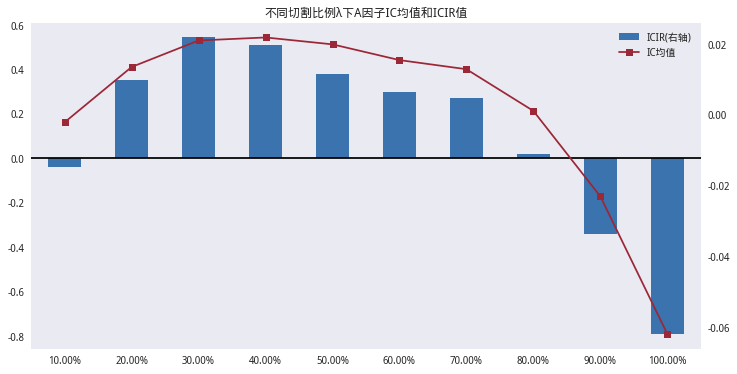

In [15]:
# 画图
mpl.rcParams['font.family']='serif'
bar = icir.plot.bar(figsize=(12, 6), color='#3A73AD',
                    title='不同切割比例λ下A因子IC均值和ICIR值', label='ICIR(右轴)')
plt.axhline(0, color='black')
line = ic_mean2.plot.line(secondary_y=True, marker='s',
                          color='#9C2737', label='IC均值', ax=bar)
plt.grid(False)

h1, l1 = bar.get_legend_handles_labels()
h2, l2 = line.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2);

图下图给出了不同λ值下A因子的多空对冲净值表现。从图上我们直观的可以感受到：在全区间内(这里为10%至30%,原始研报是10%至70%)，A因子多空表现较为稳健。随着λ逐渐增加，A因子多空收益逐渐提升。从不同分组的收益表现来看，A因子的分组收益呈现单调排列，且多头组合超额收益优势较为显著。

In [10]:
# 获取分组
def add_group(ser: pd.Series, N: int = 5) -> pd.Series:

    name = ['G%s' % x for x in range(1, N+1)]
    return pd.qcut(ser, N, labels=name)

# 获取分组收益率
def get_algorithm_ret(factor_df: pd.DataFrame, col: str) -> pd.DataFrame:

    group_ser = factor_df.groupby(level='date')[col].apply(add_group)
    group_df = pd.concat((factor_df['next_ret'], group_ser), axis=1)

    group_ret = pd.pivot_table(group_df.reset_index(
    ), index='date', columns=col, values='next_ret')
    group_ret.columns = list(map(str, group_ret.columns))
    group_ret['excess_ret'] = group_ret['G5'] - group_ret['G1']

    return group_ret

# 获取多空收益
def get_excess_ret(factor_df: pd.DataFrame, col: list) -> pd.DataFrame:

    if isinstance(col, (str, float, int)):
        col = [col]

    df = pd.concat((get_algorithm_ret(factor_df, x)[
                   'excess_ret'] for x in col), axis=1)
    df.columns = col
    return df

In [25]:
lamb_3 = get_algorithm_ret(factor_df3,'30.00%')

# 计算多空收益
excess_ret = get_excess_ret(factor_df3, list(
    map(lambda x: '%.2f%%' % x, range(10, 101, 10))))

excess_cum = ep.cum_returns(excess_ret).add(1)

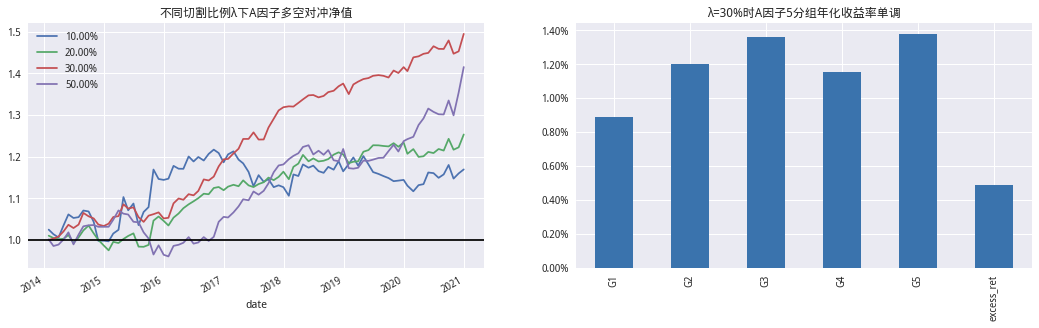

In [52]:
# 画图
mpl.rcParams['font.family']='serif'
fig,excess_plot = plt.subplots(1,2)


excess_cum[['10.00%','20.00%', '30.00%', '50.00%']].plot(
    figsize=(18, 5), title='不同切割比例λ下A因子多空对冲净值',ax=excess_plot[0])
excess_plot[0].axhline(1,color='black')


lamb_3.mean().plot.bar(title='λ=30%时A因子5分组年化收益率单调',ax=excess_plot[1],color='#3A73AD')
yaxis_format = mpl.ticker.FuncFormatter(lambda x,pos:'%.2f%%'%(x*100))
excess_plot[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(yaxis_format));

# 切割得到的动量因子在沪深 300 样本的表现

In [98]:
# 设置区间
start = '2010-01-01'
end = '2013-12-31'
last_date = '2014-01-31'

# 因子设置

f_hs300_a = creat_factor(RetN_momentum, list(
    range(21, 242, 20)), 'sort', ['A', 'B'])


# 获取因子数据 
factor_hs300_a = prepare_data(
    '000300.XSHG', start,end,last_date, f_hs300_a)

可以看到在2010至2013这个时间范围内沪深300样本内在N=120时A因子的IC均值最高

In [99]:
# IC计算
hs_ic = factor_hs300_a.fillna(0).groupby(level='date').apply(src_ic)

In [100]:
# 获取A组的mean ic
A_hs_factor = hs_ic.filter(regex='A_momentum').mean()
A_hs_factor.index = A_hs_factor.index.str.replace('\D', '')

# 获取B组的mean ic
B_hs_factor = hs_ic.filter(regex='B_momentum').mean()
B_hs_factor.index = B_hs_factor.index.str.replace('\D', '')

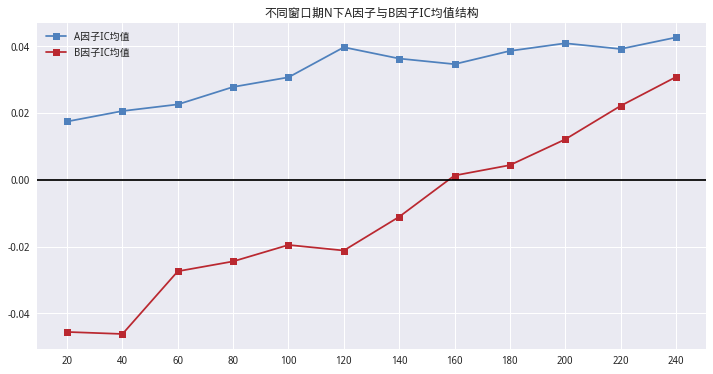

In [101]:
# 画图
fig, hs_ic_mean_ax = plt.subplots(figsize=(12, 6))

hs_ic_mean_ax.set_title('不同窗口期N下A因子与B因子IC均值结构')
hs_ic_mean_ax.plot(A_hs_factor, label='A因子IC均值', marker='s', color='#4F81BD')
hs_ic_mean_ax.plot(B_hs_factor, label='B因子IC均值', marker='s', color='#BA2830')
hs_ic_mean_ax.axhline(0, color='black')
hs_ic_mean_ax.legend()

我们在120这个窗口期下可以看到$\lambda$在10%至70%之间时ICIR持续提高，为一个安全期间。

In [109]:
f_hs300_b = creat_factor(RetN_momentum, 121, 'lamb', 'A',np.arange(0.1,1.1,0.1))

factor_hs300_b = prepare_data(
    '000300.XSHG', start,end,last_date, f_hs300_b)

In [110]:
factor_hs300_b.columns = list(map(lambda x: '%.2f%%' %
                              x, range(10, 101, 10))) + ['next_ret']

# 计算ic
hs_ic_df = factor_hs300_b.fillna(0).groupby(level='date').apply(src_ic)

hs_ic_mean = hs_ic_df.mean()
hs_ic_std = hs_ic_mean.std()

hs_icir = hs_ic_mean / hs_ic_std

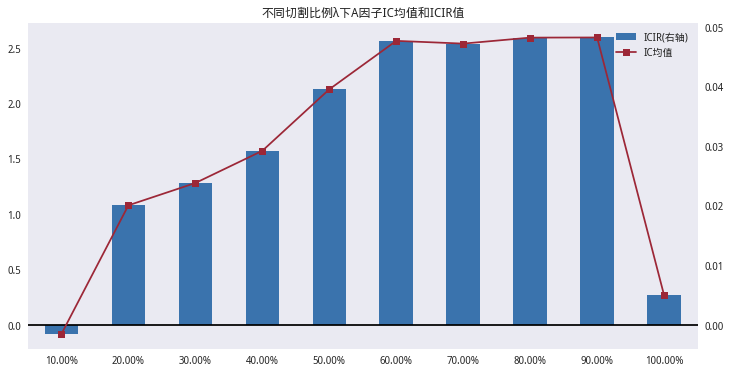

In [111]:
# 画图
mpl.rcParams['font.family']='serif'

bar = hs_icir.plot.bar(figsize=(12, 6), color='#3A73AD',
                    title='不同切割比例λ下A因子IC均值和ICIR值', label='ICIR(右轴)')
plt.axhline(0, color='black')
line = hs_ic_mean.plot.line(secondary_y=True, marker='s',
                          color='#9C2737', label='IC均值', ax=bar)
plt.grid(False)

h1, l1 = bar.get_legend_handles_labels()
h2, l2 = line.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2);

使用上述结论在2014至2020区间进行回测

In [7]:
# 设置区间
start = '2014-01-01'
end = '2020-12-31'
last_date = '2021-01-31'

# 设置因子
f_hs300 = RetN_momentum()
f_hs300.max_window = 121
f_hs300.mod = 'lamb'
f_hs300.group = 'A'
f_hs300.lamb = 0.9

# 获取因子
factor_hs300 = prepare_data(
    '000300.XSHG', start,end,last_date, [f_hs300])

In [11]:
# 获取回测收益
hs300_ret = get_algorithm_ret(factor_hs300, f_hs300.name)

benchmark = get_price('000300.XSHG', start, end, fields='close')
benchmark = benchmark.reindex(hs300_ret.index)

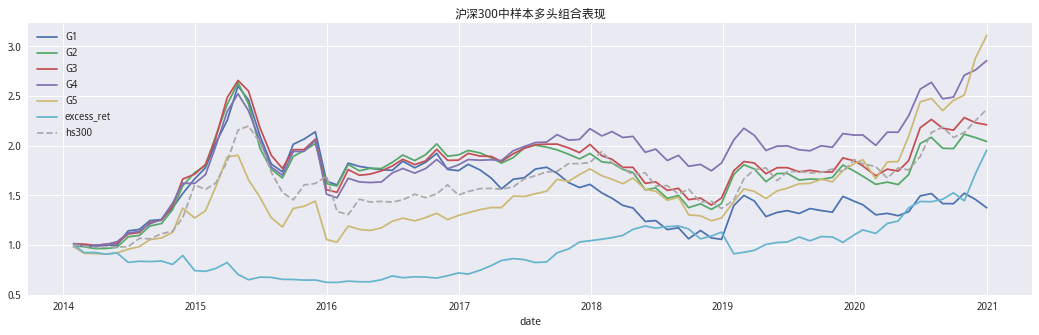

In [20]:
# 画图
mpl.rcParams['font.family']='serif'

ep.cum_returns(hs300_ret).add(1).plot(
    figsize=(18, 5), label='多空净值', title='沪深300中样本多头组合表现')

line_b = (benchmark['close'] / benchmark['close'][0]).plot(ls='--',color='darkgray',label='hs300')


h2,l2 = line_b.get_legend_handles_labels()

plt.legend(h2,l2,loc='upper left')